In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


## Agenda

In this notebook I will show how one can do multiclass classification using MNIST and hopefully provide some helper methods and references for you to use

I will load and visualize data and try certain models to compare performances of them

In [2]:
df_train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
df_test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')
df_submission = pd.read_csv('/kaggle/input/digit-recognizer/sample_submission.csv')

X = df_train.drop(["label"], axis=1)
y = df_train["label"]

In [3]:
# Divide train data to test and train for measuring accuraccy and other metrics
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [5]:
df_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Label indicates the number row corresponds to. We can verify by visualizing this.

4


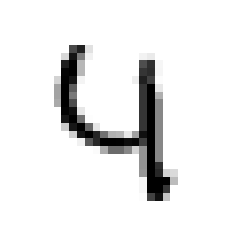

In [6]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

def draw_digit(digit_data):
    # 28 because we have 784 columns and square root is 28
    img = digit_data.reshape(28, 28)
    plt.imshow(img, cmap=mpl.cm.binary)
    plt.axis("off")
    plt.show()

print(y_train.iloc[3])
draw_digit(np.array(X_train.iloc[3]))

## Multiclass Classification


In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

params = [{'weights': ['uniform', 'distance'], 'n_neighbors': [3, 5, 10]}]

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, params, verbose=4)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ....n_neighbors=3, weights=uniform;, score=0.963 total time=   5.5s
[CV 2/5] END ....n_neighbors=3, weights=uniform;, score=0.964 total time=   5.2s
[CV 3/5] END ....n_neighbors=3, weights=uniform;, score=0.960 total time=   5.4s
[CV 4/5] END ....n_neighbors=3, weights=uniform;, score=0.964 total time=   5.2s
[CV 5/5] END ....n_neighbors=3, weights=uniform;, score=0.966 total time=   5.2s
[CV 1/5] END ...n_neighbors=3, weights=distance;, score=0.963 total time=   5.8s
[CV 2/5] END ...n_neighbors=3, weights=distance;, score=0.965 total time=   5.1s
[CV 3/5] END ...n_neighbors=3, weights=distance;, score=0.961 total time=   5.2s
[CV 4/5] END ...n_neighbors=3, weights=distance;, score=0.967 total time=   5.1s
[CV 5/5] END ...n_neighbors=3, weights=distance;, score=0.968 total time=   5.3s
[CV 1/5] END ....n_neighbors=5, weights=uniform;, score=0.963 total time=   5.8s
[CV 2/5] END ....n_neighbors=5, weights=uniform;,

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 5, 10],
                          'weights': ['uniform', 'distance']}],
             verbose=4)

In [8]:
print(grid_search.best_params_, grid_search.best_score_)

{'n_neighbors': 3, 'weights': 'distance'} 0.9648299319727892


In [9]:
from sklearn.metrics import accuracy_score

y_test_grid = grid_search.predict(X_test)
accuracy_score(y_test, y_test_grid)

0.9669047619047619

## Using Convolutional Neural Networks

Now we can try with CNN's. Before we do that though we have to rescale the data

In [10]:
X_scaled = X / 255.0
df_test = df_test / 255.0

In [11]:
X_scaled = X_scaled.values.reshape(-1, 28, 28, 1)
df_test = df_test.values.reshape(-1, 28, 28, 1)

We also need to convert the labels so they look like [0,0,1,0,0,0,0,0,0] instead of 2

In [12]:
from keras.utils.np_utils import to_categorical
y_converted = to_categorical(y, num_classes = 10)

In [13]:
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_converted, test_size = 0.3)

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

# In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

model = Sequential()
model.add(Conv2D(filters = 8, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

2023-01-11 17:52:30.859945: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-11 17:52:30.943126: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-11 17:52:30.943872: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-11 17:52:30.946283: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [16]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

In [17]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [18]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=5,
        zoom_range = 0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=False,
        vertical_flip=False)

datagen.fit(X_train_scaled)

In [19]:
history = model.fit_generator(datagen.flow(X_train_scaled,y_train_scaled, batch_size=250),
                              epochs = 10, validation_data = (X_test_scaled,y_test_scaled), steps_per_epoch=X_train.shape[0] // 250)
print(history.history.keys(), history.params)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2023-01-11 17:53:03.744425: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2023-01-11 17:53:05.149469: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


117/117 [==============================] - 14s 63ms/step - loss: 1.2331 - accuracy: 0.5834 - val_loss: 0.2756 - val_accuracy: 0.9267
Epoch 2/10
117/117 [==============================] - 7s 63ms/step - loss: 0.4940 - accuracy: 0.8402 - val_loss: 0.1514 - val_accuracy: 0.9581
Epoch 3/10
117/117 [==============================] - 7s 59ms/step - loss: 0.3514 - accuracy: 0.8885 - val_loss: 0.1208 - val_accuracy: 0.9635
Epoch 4/10
117/117 [==============================] - 7s 61ms/step - loss: 0.2911 - accuracy: 0.9092 - val_loss: 0.1072 - val_accuracy: 0.9679
Epoch 5/10
117/117 [==============================] - 7s 57ms/step - loss: 0.2572 - accuracy: 0.9197 - val_loss: 0.0860 - val_accuracy: 0.9719
Epoch 6/10
117/117 [==============================] - 7s 63ms/step - loss: 0.2313 - accuracy: 0.9275 - val_loss: 0.0787 - val_accuracy: 0.9754
Epoch 7/10
117/117 [==============================] - 8s 65ms/step - loss: 0.2185 - accuracy: 0.9329 - val_loss: 0.0698 - val_accuracy: 0.9786
Epoch 8/1

Now it is time to evaluate the model

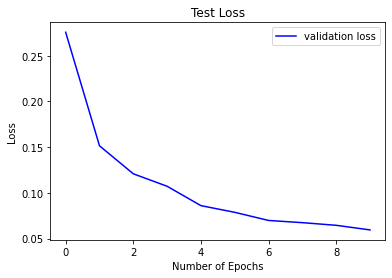

In [20]:
plt.plot(history.history['val_loss'], color='b', label="validation loss")
plt.title("Test Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

The graph above plots the loss and accuracy curve for training and test

In [ ]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

We get 99% accuracy on 2 epochs which is really good. Validation accuracy is larger than training accuracy which also means that we are not overfitting.

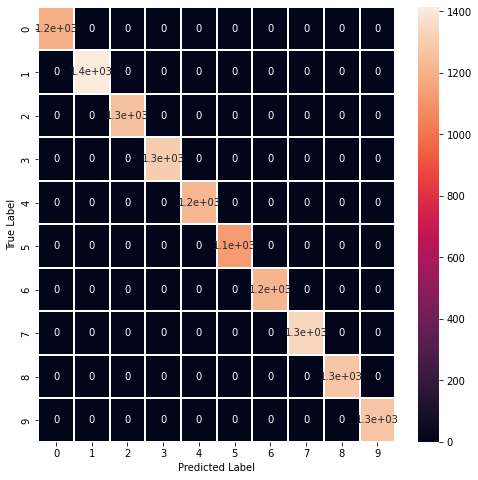

In [21]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

Y_pred = model.predict(X_test_scaled)
Y_pred_classes = np.argmax(y_test_scaled,axis = 1) 
Y_true = np.argmax(y_test_scaled,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

How do you make sense of this ? Take number 1 for true label and predicted label. If the value is > 0 for a cell it means there is a relationship between them. All other values are 0 for 1 except for 1 in true and predicted. Which means there is a correlation between true label 1 and predicted 1 which is the true prediction

Lets plot for Knn

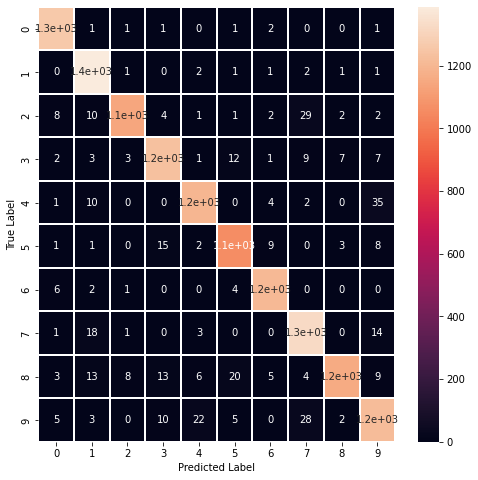

In [22]:
confusion_mtx = confusion_matrix(y_test, y_test_grid) 

f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [37]:
preds = model.predict(df_test)
preds = np.argmax(preds, axis = 1)
preds = pd.Series(preds, name="Label")

In [38]:
#submission = pd.concat([pd.Series(range(1,28001), name="ImageId"), preds],axis = 1)
#submission.to_csv("cnn_submission.csv",index=False)

In [ ]:
# TODO: Find an sklearn model as well (voting, ensemble ?
# TODO: Fine tune the model https://github.com/keras-team/keras-tuner